In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Slicing images into overlapping patches at runtime

https://gist.github.com/Chris-hughes10/ba2e074477a2e3016c50ba5befc7874f

## Selecting a Dataset

In [17]:
!pwd

/content


## Download and Prepare data

wget https://s3.amazonaws.com/fast-ai-coco/coco_sample.tgz -P data

the command above did not work so I am downloading the data from the site 'https://files.fast.ai/data/examples/' which I found after having looked up in google 'coco_sample.tgz'

In [18]:
# cd "C:\\Users\\TobarrP\\OneDrive - BASF\\jupyter notebooks 20230615\\data"

In [19]:
!ls

drive  sample_data


In [20]:
# cd coco_sample

In [21]:
ls

drive/  sample_data/


I have downloaded in windows the 'coco_sample.tgz' file, unpacked it into the 'coco_sample.tar' file. Then I moved it to the folder 'C:\Users\TobarrP\OneDrive - BASF\jupyter notebooks 20230615\data'. And finally I unpacked it into the 2 folders 'data' and 'train_sample' as shown above.

## Convert annotations to DataFrame

In [22]:
pwd

'/content'

Like the original COCO dataset, this sample uses a Json file to store the annotations. Whilst libraries such as PyCocoTools can help us interact with files in this format, I personally find that this format makes it more difficult to explore and query the data than if it was stored in a tabular format.

To simplify things, we can define a function to load the annotations as a Pandas DataFrame; here, I am also converting the bounding boxes to xyxy format, as I personally find this the most intuitive to work with. In my experience, I find that spending a little time at the start to convert the data into a format that is easy to interact with can save lots of time later that would be spent working with data in a difficult format!

In [23]:
import matplotlib.pyplot as plt
import json
import pandas as pd

In [24]:
def load_coco_annotations_as_df(annotations_path):
    with open(annotations_path, "r") as f:
        # The open() function opens a file, and returns it as a file object.
        # "r" - Read - Default value. Opens a file for reading, error if the file does not exist
        coco = json.load(f) # returns JSON object as a dictionary 'train_sample.json'

    classes_df = pd.DataFrame.from_dict(coco["categories"])
    # pd.df of categories with cols [id (int), name (string)] - (6, 2)
    annotations_df = pd.DataFrame.from_dict(coco["annotations"])
    # pd.df of annotations with cols [image_id (int), bbox ([float, float, float, float]), category_id (int)] - (87106, 3)
    images_df = pd.DataFrame.from_dict(coco["images"])
    # pd.df of annotations with cols [id (int), file_name (string) - (21837, 2)

    split_bboxes_df = pd.DataFrame(
        annotations_df["bbox"].tolist(), columns=["xmin", "ymin", "h", "w"]
    )
    # we're taking the col 'bbox', we turn it into a list,
    # we turn the column of list into a df of cols ["xmin", "ymin", "h", "w"] - [87106 rows x 4 columns]

    annotations_df = pd.concat([annotations_df, split_bboxes_df], axis=1)
    # we conct to annotations_df the 4 cols of split_bboxes_df
    # [image_id (int), bbox ([float, float, float, float]), category_id (int), "xmin", "ymin", "h", "w"]
    # [87106 rows x 7 columns]

    df = pd.merge(annotations_df, images_df, left_on="image_id", right_on="id")
    # we're inner merging annotations_df left_on="image_id", and images_df right_on="id"
    # left: use only keys from left frame, similar to a SQL left outer join; preserve key order.
    # right: use only keys from right frame, similar to a SQL right outer join; preserve key order.
    # [image_id (int), bbox ([float, float, float, float]), category_id (int), "xmin", "ymin", "h", "w", id (int), file_name (string)]
    # [87106 rows x 9 columns]

    df = pd.merge(df, classes_df, left_on="category_id", right_on="id")
    # we're inner merging df left_on="category_id", and classes_df right_on="id"
    # ie, we're adding the name to the category_id
    # [image_id (int), bbox ([float, float, float, float]), category_id (int), "xmin", "ymin", "h", "w", id (int),
    # file_name (string), id_y int, name (string)]
    # [87106 rows x 11 columns]

    # we're seleccting the followinf columns from df
    df = df[["file_name", "xmin", "ymin", "h", "w", "name"]]
    # [87106 rows x 6 columns] # name is the category name of the bounding box

    # we're adding the column "xmax" to the df as follows
    df["xmax"] = df["xmin"] + df["h"]
    # [87106 rows x 7 columns]

    # we're adding the column "xmax" to the df as follows
    df["ymax"] = df["ymin"] + df["w"]
    # [87106 rows x 8 columns]

    # we're getting to column df.name and we are extracting in a list its unique values with the function .unique()
    # then we enumerate the elements in that list in tuples of the form (index, unique value element)
    # then we convert that enumeration of tuples into a dictionary of the form 'element': index + 1
    name_to_id_lookup = {n: i + 1 for i, n in enumerate(df.name.unique())}
    # {'tv': 1, 'book': 2, 'chair': 3, 'vase': 4, 'remote': 5, 'couch': 6}

    # then we're adding a column df["category_id"] with the values of the dictionary 'name_to_id_lookup'
    df["category_id"] = df.name.apply(lambda x: name_to_id_lookup[x])

    # we finally return the df and the dictionary name_to_id_lookup
    return df, name_to_id_lookup

In [25]:
pwd

'/content'

In [28]:
from pathlib import Path
# data_path = Path('C:\\Users\\TobarrP\\OneDrive - BASF\\jupyter notebooks 20230615\\data\\coco_sample')
data_path = Path('/content/drive/MyDrive/data/coco_sample')
images_path = data_path/'train_sample'
annotations_file_path = data_path/'annotations/train_sample.json'

In [29]:
# df, name_to_id_lookup = load_coco_annotations_as_df(annotations_file_path)

df, name_to_id_lookup = load_coco_annotations_as_df(annotations_file_path)

In [30]:
df.head()

file_name    xmin    ymin      h       w name    xmax    ymax  \
0  000000318219.jpg  505.24    0.00  47.86  309.25   tv  553.10  309.25   
1  000000318219.jpg  470.68    0.00  45.93  191.86   tv  516.61  191.86   
2  000000318219.jpg  442.51    0.00  43.39  119.87   tv  485.90  119.87   
3  000000554625.jpg  380.74  112.85  40.62  248.82   tv  421.36  361.67   
4  000000554625.jpg  339.13   32.99  32.99  175.50   tv  372.12  208.49   

   category_id  
0            1  
1            1  
2            1  
3            1  
4            1

In [31]:
print(df)

              file_name    xmin    ymin       h       w   name    xmax  \
0      000000318219.jpg  505.24    0.00   47.86  309.25     tv  553.10   
1      000000318219.jpg  470.68    0.00   45.93  191.86     tv  516.61   
2      000000318219.jpg  442.51    0.00   43.39  119.87     tv  485.90   
3      000000554625.jpg  380.74  112.85   40.62  248.82     tv  421.36   
4      000000554625.jpg  339.13   32.99   32.99  175.50     tv  372.12   
...                 ...     ...     ...     ...     ...    ...     ...   
87101  000000350506.jpg  252.42  274.42  184.68   95.97  couch  437.10   
87102  000000250249.jpg    2.07   92.87  477.93  423.26  couch  480.00   
87103  000000179961.jpg    1.22   30.86  353.80  222.92  couch  355.02   
87104  000000086581.jpg    1.61    3.32  498.39  366.93  couch  500.00   
87105  000000098205.jpg    0.00  100.59  136.58  149.29  couch  136.58   

         ymax  category_id  
0      309.25            1  
1      191.86            1  
2      119.87           

In [32]:
name_to_id_lookup

{'tv': 1, 'book': 2, 'chair': 3, 'vase': 4, 'remote': 5, 'couch': 6}

## Restrict data sample

To represent this scenario, let's restrict our attention to the 'remote' class, which are small objects. We can do this easily by using Pandas' query method, as demonstrated below.

In [33]:
remote_df = df.query('name == "remote"')

In [34]:
remote_df

file_name    xmin    ymin       h      w    name    xmax  \
75624  000000085160.jpg  172.13  282.57   29.83  32.75  remote  201.96   
75625  000000551334.jpg  346.97  246.62   51.92   8.60  remote  398.89   
75626  000000480076.jpg    0.31  258.16  102.15  23.87  remote  102.46   
75627  000000480076.jpg    3.66  254.04   71.98  12.58  remote   75.64   
75628  000000480076.jpg    0.00  246.52   65.38  11.70  remote   65.38   
...                 ...     ...     ...     ...    ...     ...     ...   
81322  000000296477.jpg  175.63  361.49   28.35   9.08  remote  203.98   
81323  000000158647.jpg  276.38   56.93   56.55  40.15  remote  332.93   
81324  000000350506.jpg  226.18  314.93   25.00   6.40  remote  251.18   
81325  000000250249.jpg  304.76  255.28   33.21  23.64  remote  337.97   
81326  000000049713.jpg  386.05  373.36   23.91   8.59  remote  409.96   

         ymax  category_id  
75624  315.32            5  
75625  255.22            5  
75626  282.03            5  
75627  266.62            5  
75628  258.22            5  
...       ...          ...  
81322  370.57            5  
81323   97.08            5  
81324  321.33            5  
81325  278.92            5  
81326  381.95            5  

[5703 rows x 9 columns]

Here, we can see that we are left with only annotations corresponding to the positions of remotes in our images.

5703 rows compared to the 87106 rows of 'df'.

In [35]:
len(remote_df.file_name.unique())

3076

We have 3076 different annotations corresponding to the positions of remotes in our images.

## Define plotting helper functions

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import patches

def get_rectangle_params_from_pascal_bbox(bbox):
    xmin_top_left, ymin_top_left, xmax_bottom_right, ymax_bottom_right = bbox

    bottom_left = (xmin_top_left, ymax_bottom_right)
    width = xmax_bottom_right - xmin_top_left
    height = ymin_top_left - ymax_bottom_right

    return bottom_left, width, height

def draw_bboxes(
    plot_ax,
    bboxes,
    class_labels,
    get_rectangle_corners_fn=get_rectangle_params_from_pascal_bbox,
):
    for bbox, label in zip(bboxes, class_labels):
        bottom_left, width, height = get_rectangle_corners_fn(bbox)

        """
        The matplotlib.patches.Rectangle class is used to rectangle patch to a plot with lower left at xy = (x, y)
        with specified width, height and rotation angle.

        class matplotlib.patches.Rectangle(xy, width, height, angle=0.0, **kwargs)
        linewidth or linewidths or lw - float or None
        edgecolor or ec or edgecolors - color or None or ‘auto’
        fill - bool
        """

        rect_1 = patches.Rectangle(
            bottom_left, width, height, linewidth=4, edgecolor="black", fill=False,
        )
        rect_2 = patches.Rectangle(
            bottom_left, width, height, linewidth=2, edgecolor="white", fill=False,
        )

        """
        matplotlib.patches.Rectangle.get_xy() - Return the left and bottom coords of the rectangle as a tuple.
        """
        rx, ry = rect_1.get_xy()

        """
        The Matplotlib.axes.Axes.add_patch() method in the axes module of matplotlib library is used to add a Patch
        to the axes’ patches; return the patch.
        Syntax: Axes.add_patch(self, p)
        Parameters: This method accepts the following parameters.
        - line: This parameter is the Patch to the axes’ patches.
        Return value: This method returns the Patch.
        """

        """
        matplotlib.pyplot.annotate(text, xy, xytext=None, xycoords='data', textcoords=None, arrowprops=None, annotation_clip=None, **kwargs)

        Annotate the point xy with text text. In the simplest form, the text is placed at xy.

        Parameters:
        - text: str - The text of the annotation.
        - xy: (float, float) - The point (x, y) to annotate. The coordinate system is determined by xycoords.
        - xycoords: single or two-tuple of str or 'Artist' or 'Transform' or callable, default: 'data'.
            - 'data': Use the coordinate system of the object being annotated (default)

        https://matplotlib.org/stable/tutorials/text/text_props.html
        Text properties and layout - Controlling properties of text and its layout with Matplotlib.

        matplotlib.text.Text instances have a variety of properties which can be configured via keyword arguments to set_title, set_xlabel, text, etc.
         - color: any matplotlib color
         - size or fontsize: [ size in points | relative size, e.g., 'smaller', 'x-large' ]
        """

        # Add the patch to the Axes
        plot_ax.add_patch(rect_1)
        plot_ax.add_patch(rect_2)
        plot_ax.annotate(label, (rx+width, ry+height), color='white', fontsize=20)

"""
https://matplotlib.org/stable/gallery/subplots_axes_and_figures/figure_size_units.html
Figure size in different units
The native figure size unit in Matplotlib is inches, deriving from print industry standards.
Figure size in inches (default)
plt.subplots(figsize=(6, 2))
"""

"""
The Matplotlib subplots() function in the Pyplot module of the Matplotlib library is used to create a figure and a set of
subplots.
Syntax: matplotlib.pyplot.subplots(nrows=1, ncols=1, sharex=False, sharey=False, squeeze=True, subplot_kw=None,
gridspec_kw=None, **fig_kw)
- nrows, ncols : These parameters are the number of rows/columns of the subplot grid.

Returns: This method return the following values.
- fig : This method return the figure layout.
- ax : This method return the axes.Axes object or array of Axes objects.
"""

def show_image(image, bboxes=None, class_labels=None, draw_bboxes_fn=draw_bboxes):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)

    if bboxes:
        draw_bboxes_fn(ax, bboxes, class_labels)

    plt.show()

## Create dataset adaptor

To help us explore our data, lets create an adaptor class that wraps our DataFrame and can be used to load images. When working with PyTorch, I often find it beneficial to abstract the loading of images and annotations to such a class, which can then be passed to a task-specific dataset class; this makes it easy to change the underlying dataset whilst making minimal code changes.

We can define our adaptor class as demonstrated below:

In [37]:
from pathlib import Path
from PIL import Image

import numpy as np

class DatasetAdaptor:
    def __init__(self, images_dir_path, annotations_dataframe):
        self.images_dir_path = Path(images_dir_path)
        self.annotations_df = annotations_dataframe
        self.file_name_to_idx = {
            image_id: idx
            for idx, image_id in enumerate(self.annotations_df.file_name.unique())

        }
        self.idx_to_file_name = {v: k for k, v, in self.file_name_to_idx.items()}
        """
        https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.unique.html
        pandas.unique(values)
        Return unique values based on a hash table.
        Uniques are returned in order of appearance. This does NOT sort.

        Parameters: values: 1d array-like
        Returns: numpy.ndarray or ExtensionArray
            The return can be:
            - Index : when the input is an Index
            - Categorical : when the input is a Categorical dtype
            - ndarray : when the input is a Series/ndarray
            Return numpy.ndarray or ExtensionArray.

        Examples:
        pd.unique(pd.Series([2, 1, 3, 3]))
        array([2, 1, 3])
        """

    def __len__(self) -> int:
        return len(self.file_name_to_idx)

    def __getitem__(self, index):
        file_name = self.idx_to_file_name[index]
        image = Image.open(self.images_dir_path / file_name)
        xyxy_bboxes = self.annotations_df.query("file_name == @file_name")[
            ["xmin", "ymin", "xmax", "ymax"]
        ].values
        class_labels = self.annotations_df.query("file_name == @file_name")[
            "category_id"
        ].values

        return np.array(image), xyxy_bboxes, class_labels, index

Here, we can see that, whilst this class looks like a PyTorch map-style dataset, we haven't explicitly subclassed the PyTorch's Dataset class; this will enable us to use this to explore data in environments without installing PyTorch. Due to Python's use of duck typing, as this class provides the correct interface, we can also use this as a PyTorch dataset without issue!

Now, we can now use this to easily inspect some of our data:

In [38]:
images_path

PosixPath('/content/drive/MyDrive/data/coco_sample/train_sample')

In [39]:
remote_df

file_name    xmin    ymin       h      w    name    xmax  \
75624  000000085160.jpg  172.13  282.57   29.83  32.75  remote  201.96   
75625  000000551334.jpg  346.97  246.62   51.92   8.60  remote  398.89   
75626  000000480076.jpg    0.31  258.16  102.15  23.87  remote  102.46   
75627  000000480076.jpg    3.66  254.04   71.98  12.58  remote   75.64   
75628  000000480076.jpg    0.00  246.52   65.38  11.70  remote   65.38   
...                 ...     ...     ...     ...    ...     ...     ...   
81322  000000296477.jpg  175.63  361.49   28.35   9.08  remote  203.98   
81323  000000158647.jpg  276.38   56.93   56.55  40.15  remote  332.93   
81324  000000350506.jpg  226.18  314.93   25.00   6.40  remote  251.18   
81325  000000250249.jpg  304.76  255.28   33.21  23.64  remote  337.97   
81326  000000049713.jpg  386.05  373.36   23.91   8.59  remote  409.96   

         ymax  category_id  
75624  315.32            5  
75625  255.22            5  
75626  282.03            5  
75627  266.62            5  
75628  258.22            5  
...       ...          ...  
81322  370.57            5  
81323   97.08            5  
81324  321.33            5  
81325  278.92            5  
81326  381.95            5  

[5703 rows x 9 columns]

In [40]:
ds = DatasetAdaptor(images_path, remote_df)

In [41]:
ds

In [42]:
idx = 6

image, bboxes, class_labels, image_id = ds[idx]

In [43]:
ds[idx]

(array([[[145, 146, 148],
         [145, 146, 148],
         [145, 146, 148],
         ...,
         [169, 168, 173],
         [168, 167, 172],
         [168, 167, 172]],
 
        [[146, 147, 149],
         [146, 147, 149],
         [146, 147, 149],
         ...,
         [171, 170, 175],
         [170, 169, 174],
         [170, 169, 174]],
 
        [[147, 148, 150],
         [148, 149, 151],
         [149, 149, 151],
         ...,
         [173, 173, 175],
         [172, 172, 174],
         [172, 172, 174]],
 
        ...,
 
        [[ 97,  57,  32],
         [103,  61,  37],
         [102,  60,  36],
         ...,
         [111, 103, 100],
         [ 98,  89,  84],
         [ 81,  72,  67]],
 
        [[ 94,  53,  31],
         [ 97,  57,  32],
         [ 99,  59,  34],
         ...,
         [112, 104, 101],
         [101,  92,  87],
         [ 88,  77,  71]],
 
        [[ 90,  52,  29],
         [ 91,  53,  30],
         [ 93,  56,  30],
         ...,
         [107,  99,  96],
  

In [44]:
image

array([[[145, 146, 148],
        [145, 146, 148],
        [145, 146, 148],
        ...,
        [169, 168, 173],
        [168, 167, 172],
        [168, 167, 172]],

       [[146, 147, 149],
        [146, 147, 149],
        [146, 147, 149],
        ...,
        [171, 170, 175],
        [170, 169, 174],
        [170, 169, 174]],

       [[147, 148, 150],
        [148, 149, 151],
        [149, 149, 151],
        ...,
        [173, 173, 175],
        [172, 172, 174],
        [172, 172, 174]],

       ...,

       [[ 97,  57,  32],
        [103,  61,  37],
        [102,  60,  36],
        ...,
        [111, 103, 100],
        [ 98,  89,  84],
        [ 81,  72,  67]],

       [[ 94,  53,  31],
        [ 97,  57,  32],
        [ 99,  59,  34],
        ...,
        [112, 104, 101],
        [101,  92,  87],
        [ 88,  77,  71]],

       [[ 90,  52,  29],
        [ 91,  53,  30],
        [ 93,  56,  30],
        ...,
        [107,  99,  96],
        [104,  95,  90],
        [ 91,  80,  74]]

In [45]:
image.shape

(375, 500, 3)

In [46]:
bboxes

array([[119.92, 287.43, 137.17, 319.21],
       [157.35, 278.27, 177.52, 319.36]])

In [47]:
bboxes.shape

(2, 4)

In [48]:
class_labels

array([5, 5])

In [49]:
class_labels.shape

(2,)

In [50]:
image_id

6

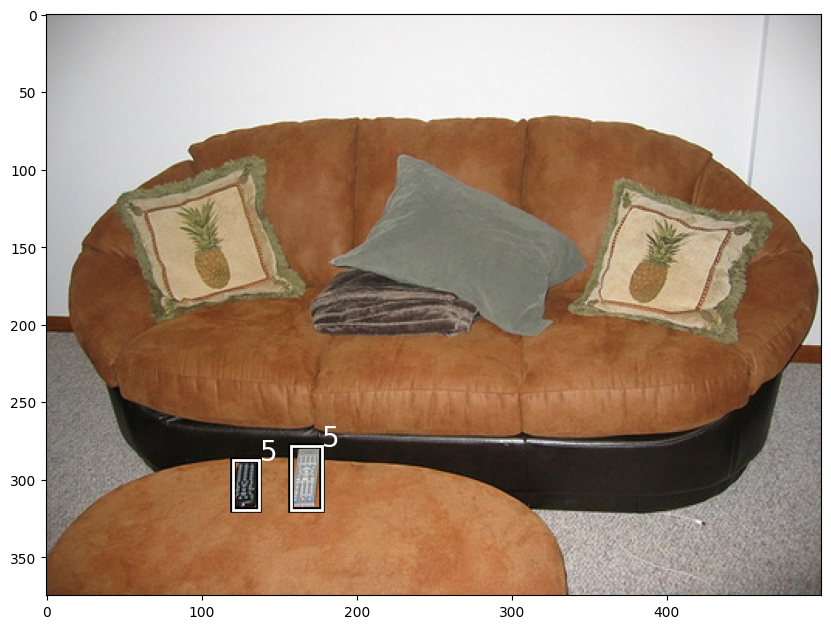

In [51]:
show_image(image, bboxes.tolist(), class_labels.tolist())

In [52]:
ds.idx_to_file_name[6]

'000000371250.jpg'

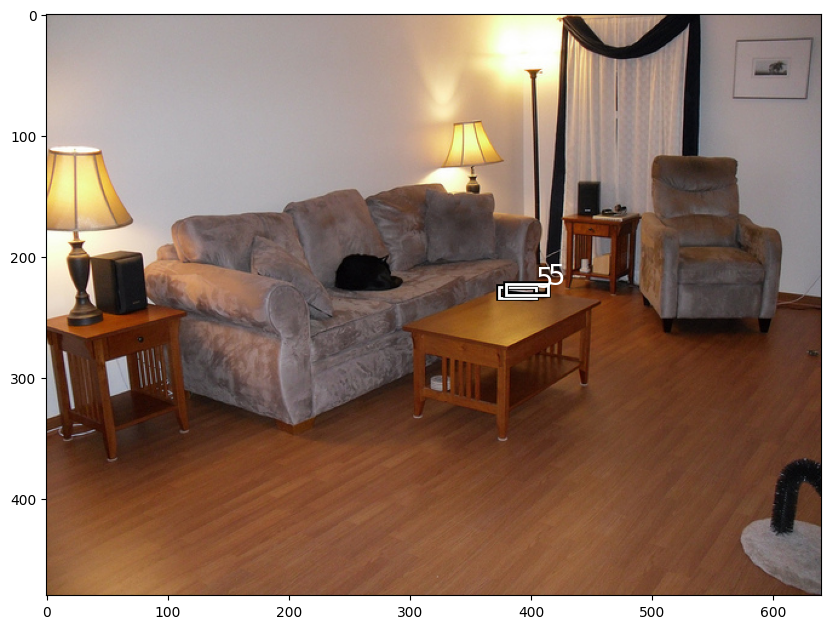

In [53]:
idx = 18
image, bboxes, class_labels, image_id = ds[idx]
show_image(image, bboxes.tolist(), class_labels.tolist())

In [54]:
bboxes

array([[373.36, 225.02, 404.13, 234.33],
       [378.99, 222.69, 414.13, 231.32]])

In [55]:
class_labels

array([5, 5])

In [56]:
image_id

18

In [57]:
image.shape

(480, 640, 3)

In [58]:
ds.idx_to_file_name[18]

'000000199449.jpg'

In [59]:
ds.idx_to_file_name[idx]

'000000199449.jpg'

One last example

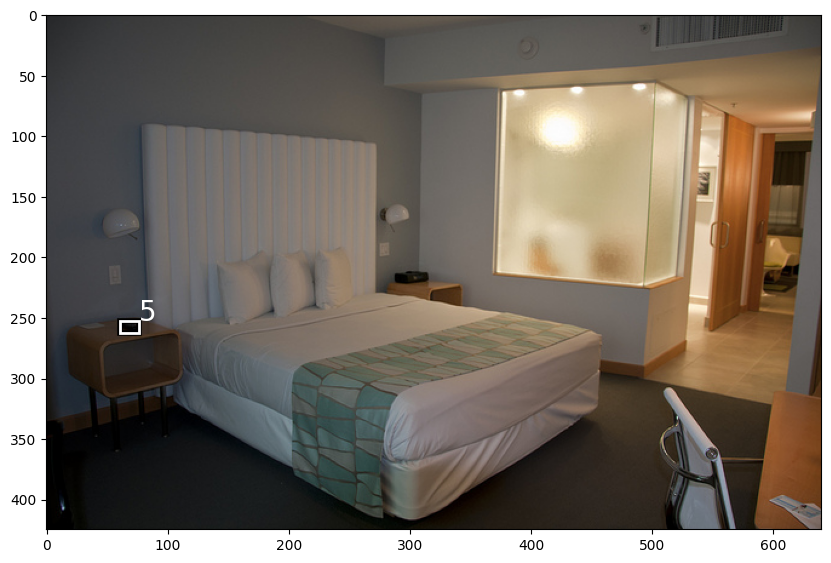

In [60]:
idx = 37
image, bboxes, class_labels, image_id = ds[idx]
show_image(image, bboxes.tolist(), class_labels.tolist())

In [61]:
bboxes

array([[ 60.67, 252.24,  76.37, 262.23]])

In [62]:
class_labels

array([5])

In [63]:
image_id, image.shape

(37, (425, 640, 3))

In [64]:
ds.idx_to_file_name[37], ds.idx_to_file_name[idx]

('000000380244.jpg', '000000380244.jpg')

Plotting some of our images and labels, we can see that it seems to be working correctly!

## Slicing Images

Now that we have loaded our data, let's explore how we can slice our images into smaller patches. During inference, we will probably want to ensure that all of the image is represented, so we can take a sliding window approach of how to slice up the image.

As previously discussed, we would like to pre-calculate these slices ahead of time, in a way that they can be applied at runtime; without storing additional image files. One way that we can implement this is to store each slice as a bounding box, which can then be used to crop the image.

### Calculating slices

We can define a function to calculate how many slices we would need for a given image depending on its dimensions, and return the coordinates for each slice as a bounding box in xyxy format, as demonstrated below:

In [65]:
# adapted from https://github.com/obss/sahi/blob/e798c80d6e09079ae07a672c89732dd602fe9001/sahi/slicing.py#L30, MIT License

def calculate_slice_bboxes(
    image_height: int,
    image_width: int,
    slice_height: int = 512,
    slice_width: int = 512,
    overlap_height_ratio: float = 0.2,
#         overlap_width_ratio: float = 0.2,
# ) -> list[list[int]]:
    overlap_width_ratio: float = 0.2
):
    """
    Given the height and width of an image, calculates how to divide the image into
    overlapping slices according to the height and width provided. These slices are returned
    as bounding boxes in xyxy format.

    :param image_height: Height of the original image.
    :param image_width: Width of the original image.
    :param slice_height: Height of each slice
    :param slice_width: Width of each slice
    :param overlap_height_ratio: Fractional overlap in height of each slice (e.g. an overlap of 0.2 for a slice of size 100 yields an overlap of 20 pixels)
    :param overlap_width_ratio: Fractional overlap in width of each slice (e.g. an overlap of 0.2 for a slice of size 100 yields an overlap of 20 pixels)
    :return: a list of bounding boxes in xyxy format
    """

    slice_bboxes = []
    y_max = y_min = 0
    y_overlap = int(overlap_height_ratio * slice_height)
    x_overlap = int(overlap_width_ratio * slice_width)
    while y_max < image_height:
        x_min = x_max = 0
        y_max = y_min + slice_height
        while x_max < image_width:
            x_max = x_min + slice_width
            if y_max > image_height or x_max > image_width:
                xmax = min(image_width, x_max)
                ymax = min(image_height, y_max)
                xmin = max(0, xmax - slice_width)
                ymin = max(0, ymax - slice_height)
                slice_bboxes.append([xmin, ymin, xmax, ymax])
            else:
                slice_bboxes.append([x_min, y_min, x_max, y_max])
            x_min = x_max - x_overlap
        y_min = y_max - y_overlap
    return slice_bboxes

In this function, we have also included the option to specify how much overlap each slice should have; this can be beneficial for avoiding situations where a small object is split over multiple slices. Additionally, depending on the height and width selected for each slice, and the size of the image, we may find that some overlapping is necessary to ensure that all slices are the same size.

Now, let's set some parameters for our slices. Here, we arbitrarily choose a slice size of 250 with no overlap unless necessary.

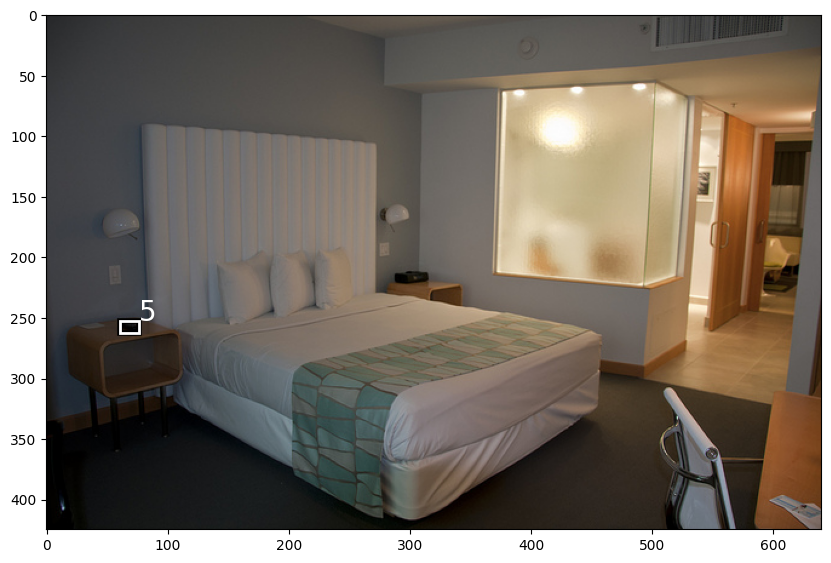

In [66]:
show_image(image, bboxes.tolist(), class_labels.tolist())

In [67]:
image.shape

(425, 640, 3)

In [68]:
image_height = image.shape[0]
image_width = image.shape[1]
slice_height: int = 250
slice_width: int = 250
overlap_height_ratio: float = 0.
overlap_width_ratio: float = 0.

In [69]:
slices = calculate_slice_bboxes(image_height,
                                image_width,
                                slice_height,
                                slice_width,
                                overlap_height_ratio,
                                overlap_width_ratio)

In [70]:
slices

[[0, 0, 250, 250],
 [250, 0, 500, 250],
 [390, 0, 640, 250],
 [0, 175, 250, 425],
 [250, 175, 500, 425],
 [390, 175, 640, 425]]

Here, we can see that, using these settings, we have six different slices of our image.

## Slicing the image
Now that we have the bounding boxes representing our slices, we can visualise these as demonstrated below:

In [71]:
for slice_idx, slice_bbox in enumerate(slices):
    show_image(image, [slice_bbox], [''])

Output hidden; open in https://colab.research.google.com to view.

Also, it is easy to use these bounding boxes to crop our image, as demonstrated below:

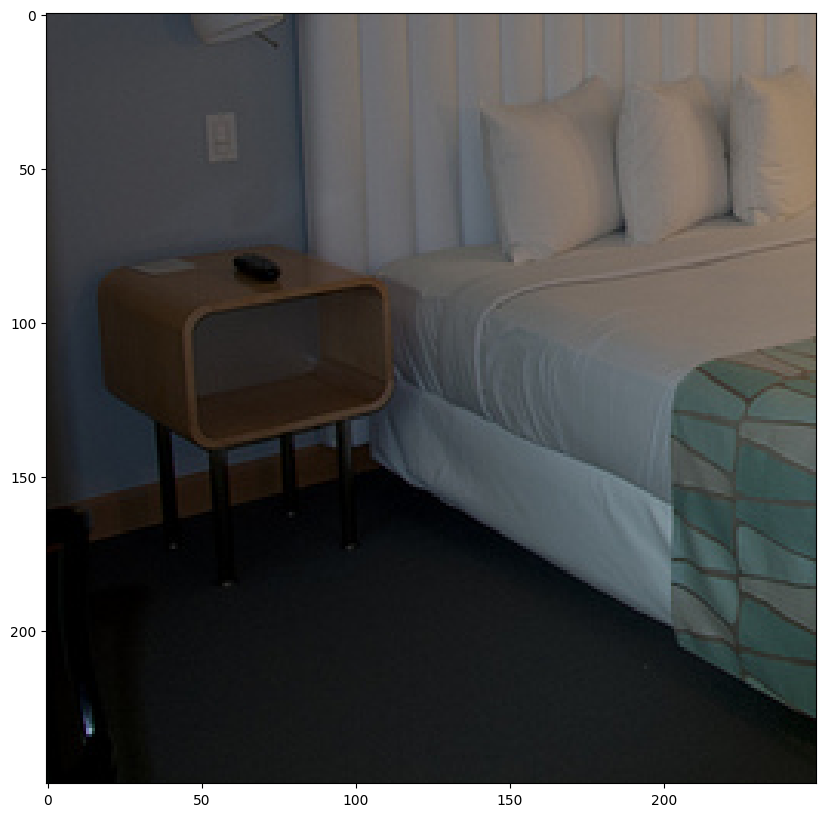

In [72]:
slice_index = 3
xmin, ymin, xmax, ymax = slices[slice_index]
show_image(image[ymin:ymax, xmin:xmax,])

## Scaling the annotations
As we are slicing our image into smaller patches, we will also have to modify our bounding box annotations in two ways:

* for each slice, we need to determine which bounding boxes are contained in this slice
* for the bounding boxes present, we need to scale the boxes so that they are relative to the containing slice.

Thankfully, the excellent Albumentations library contains this functionality as part of its Crop transform, so let's leverage this here.

In [73]:
import albumentations as A

In [74]:
slice_index

3

In [75]:
crop_transform = A.Compose(
        [A.Crop(*slices[slice_index]),],
        bbox_params=A.BboxParams(format="pascal_voc",
                                 label_fields=['labels'],
                                 min_visibility=0.1,
                                 min_area=0.1),
    )

In [76]:
transformed = crop_transform(image=image, bboxes=bboxes, labels=class_labels)

In [77]:
transformed

{'image': array([[[ 60,  59,  65],
         [ 62,  61,  67],
         [ 60,  61,  66],
         ...,
         [140, 130, 120],
         [145, 132, 123],
         [148, 132, 117]],
 
        [[ 59,  60,  65],
         [ 62,  63,  68],
         [ 63,  64,  69],
         ...,
         [141, 131, 122],
         [145, 133, 121],
         [149, 133, 118]],
 
        [[ 60,  61,  66],
         [ 62,  63,  68],
         [ 62,  63,  68],
         ...,
         [140, 130, 121],
         [145, 133, 121],
         [149, 133, 118]],
 
        ...,
 
        [[  2,   4,   3],
         [  0,   1,   0],
         [  0,   0,   0],
         ...,
         [ 19,  20,  15],
         [ 19,  20,  15],
         [ 21,  22,  17]],
 
        [[  3,   5,   4],
         [  0,   2,   1],
         [  0,   0,   0],
         ...,
         [ 20,  21,  16],
         [ 22,  23,  18],
         [ 20,  21,  16]],
 
        [[  5,   9,   8],
         [  0,   1,   0],
         [  0,   0,   0],
         ...,
         [ 20,  21,

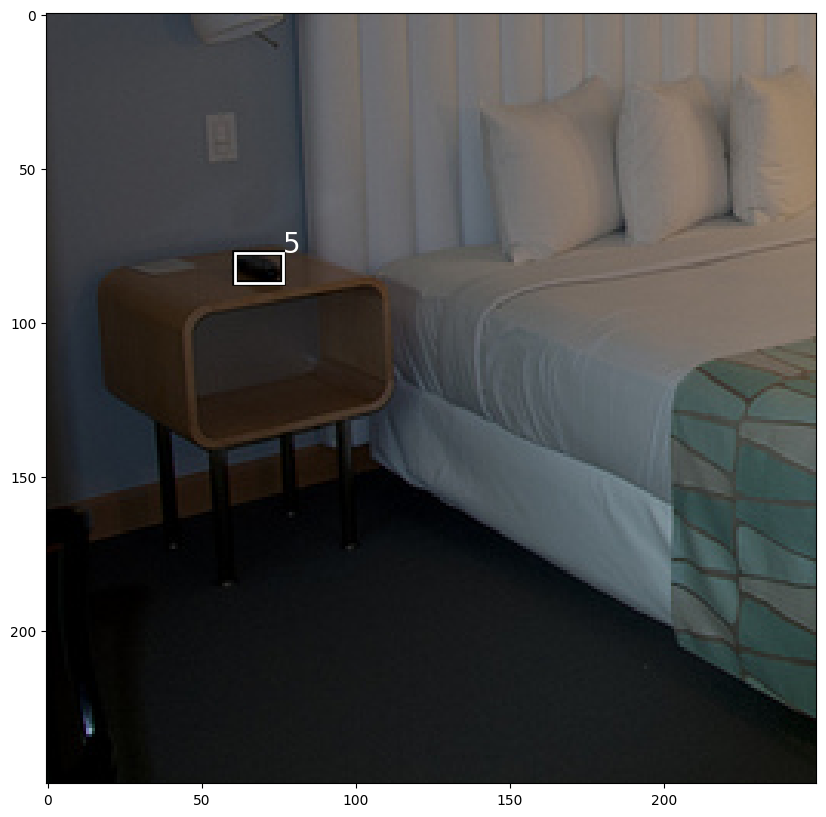

In [78]:
show_image(transformed['image'], transformed['bboxes'], transformed['labels'])

Here, we can see that the boxes are displayed correctly, even though the image has been cropped.

## Creating a slices DataFrame

Now that we have explored how to slice our images and modify our labels, the next step is to store this in a DataFrame.

### Finding Image sizes

In the dataset that we are using, the images have different sizes. This can pose a problem to us as, to calculate our slices, we will need to know the size of each image ahead of time. To do this in an efficient manner, we can use multiprocessing to open each image and store the height and width.

If all images in the dataset were the same size, we could skip this step and specify the height and width values as a parameter.

We can define a function to do this as demonstrated below:

In [79]:
import os
from functools import partial
from PIL import Image

from multiprocessing import Pool


def get_image_sizes_df(images_path, file_names):
    pool = Pool(processes=len(os.sched_getaffinity(0)))
    image_sizes = pool.map(partial(get_image_size, images_path=images_path), file_names)
    sizes_df = pd.DataFrame(image_sizes)
    return sizes_df


def get_image_size(file_name, images_path):
    image = Image.open(images_path / file_name)
    w, h = image.size
    return {"file_name": file_name, "image_height": h, "image_width": w}

We can use this to get the height and width of each image in a DataFrame, as demonstrated below.

In [80]:
images_path

PosixPath('/content/drive/MyDrive/data/coco_sample/train_sample')

In [81]:
remote_df.file_name.unique()

array(['000000085160.jpg', '000000551334.jpg', '000000480076.jpg', ...,
       '000000350506.jpg', '000000250249.jpg', '000000049713.jpg'],
      dtype=object)

In [82]:
remote_df.file_name.unique().shape

(3076,)

In [83]:
remote_df

file_name    xmin    ymin       h      w    name    xmax  \
75624  000000085160.jpg  172.13  282.57   29.83  32.75  remote  201.96   
75625  000000551334.jpg  346.97  246.62   51.92   8.60  remote  398.89   
75626  000000480076.jpg    0.31  258.16  102.15  23.87  remote  102.46   
75627  000000480076.jpg    3.66  254.04   71.98  12.58  remote   75.64   
75628  000000480076.jpg    0.00  246.52   65.38  11.70  remote   65.38   
...                 ...     ...     ...     ...    ...     ...     ...   
81322  000000296477.jpg  175.63  361.49   28.35   9.08  remote  203.98   
81323  000000158647.jpg  276.38   56.93   56.55  40.15  remote  332.93   
81324  000000350506.jpg  226.18  314.93   25.00   6.40  remote  251.18   
81325  000000250249.jpg  304.76  255.28   33.21  23.64  remote  337.97   
81326  000000049713.jpg  386.05  373.36   23.91   8.59  remote  409.96   

         ymax  category_id  
75624  315.32            5  
75625  255.22            5  
75626  282.03            5  
75627  266.62            5  
75628  258.22            5  
...       ...          ...  
81322  370.57            5  
81323   97.08            5  
81324  321.33            5  
81325  278.92            5  
81326  381.95            5  

[5703 rows x 9 columns]

In [84]:
# i'm making a list of the 3 images we're working with in the example of this notebook
train_sample_list = ['000000199449.jpg', '000000371250.jpg', '000000380244.jpg']
train_sample_list

['000000199449.jpg', '000000371250.jpg', '000000380244.jpg']

In [85]:
# i'm keeping only the rows referring to any of ther file_names included in the list above
remote_df = remote_df[remote_df['file_name'].isin(train_sample_list)]
remote_df

file_name    xmin    ymin      h      w    name    xmax    ymax  \
75634  000000371250.jpg  119.92  287.43  17.25  31.78  remote  137.17  319.21   
75635  000000371250.jpg  157.35  278.27  20.17  41.09  remote  177.52  319.36   
75648  000000199449.jpg  373.36  225.02  30.77   9.31  remote  404.13  234.33   
75649  000000199449.jpg  378.99  222.69  35.14   8.63  remote  414.13  231.32   
75677  000000380244.jpg   60.67  252.24  15.70   9.99  remote   76.37  262.23   

       category_id  
75634            5  
75635            5  
75648            5  
75649            5  
75677            5

In [86]:
images_path

PosixPath('/content/drive/MyDrive/data/coco_sample/train_sample')

In [87]:
remote_df.file_name.unique()

array(['000000371250.jpg', '000000199449.jpg', '000000380244.jpg'],
      dtype=object)

In [88]:
remote_df.file_name.unique().shape

(3,)

In [89]:
sizes_df = get_image_sizes_df(images_path, remote_df.file_name.unique())

In [90]:
sizes_df.head()

file_name  image_height  image_width
0  000000371250.jpg           375          500
1  000000199449.jpg           480          640
2  000000380244.jpg           425          640

In [91]:
sizes_df.shape

(3, 3)

## Calculating and storing slices

Now that we know the sizes of each image, we can use the function that we defined earlier to calculate our image slices and add this as an additional column to our DataFrame.

In [92]:
slice_height: int = 250
slice_width: int = 250
overlap_height_ratio: float = 0.
overlap_width_ratio: float = 0.

In [93]:
sizes_df["slices"] = sizes_df.apply(
    lambda row: calculate_slice_bboxes(
        row.image_height,
        row.image_width,
        slice_height,
        slice_width,
        overlap_height_ratio,
        overlap_width_ratio,
    ),
    axis=1,
)

In [94]:
sizes_df.head()

file_name  image_height  image_width  \
0  000000371250.jpg           375          500   
1  000000199449.jpg           480          640   
2  000000380244.jpg           425          640   

                                              slices  
0  [[0, 0, 250, 250], [250, 0, 500, 250], [0, 125...  
1  [[0, 0, 250, 250], [250, 0, 500, 250], [390, 0...  
2  [[0, 0, 250, 250], [250, 0, 500, 250], [390, 0...

In [95]:
sizes_df['slices'].head()

0    [[0, 0, 250, 250], [250, 0, 500, 250], [0, 125...
1    [[0, 0, 250, 250], [250, 0, 500, 250], [390, 0...
2    [[0, 0, 250, 250], [250, 0, 500, 250], [390, 0...
Name: slices, dtype: object

In [96]:
sizes_df['slices'].shape

(3,)

In [97]:
sizes_df['slices'][0]

[[0, 0, 250, 250],
 [250, 0, 500, 250],
 [0, 125, 250, 375],
 [250, 125, 500, 375]]

In [98]:
sizes_df['slices'][1]

[[0, 0, 250, 250],
 [250, 0, 500, 250],
 [390, 0, 640, 250],
 [0, 230, 250, 480],
 [250, 230, 500, 480],
 [390, 230, 640, 480]]

In [99]:
sizes_df['slices'][2]

[[0, 0, 250, 250],
 [250, 0, 500, 250],
 [390, 0, 640, 250],
 [0, 175, 250, 425],
 [250, 175, 500, 425],
 [390, 175, 640, 425]]

As we can see, we now have a list of slices bounding boxes for each image. However, as each slice represents an image, let's modify our DataFrame so that we have one slice per row of our DataFrame. Additionally, storing values as a list can cause problems when saving and loading DataFrames, so let's also separate each slice coordinate into its own column.

We can do this as demonstrated below:

In [100]:
slices_row_df = sizes_df[['file_name', 'slices']].explode('slices').rename(columns={'slices': 'slice'})
slices_row_df = pd.DataFrame(slices_row_df.slice.tolist(),
                             columns=['xmin', 'ymin', 'xmax', 'ymax'],
                             index=slices_row_df.file_name).reset_index()

In [101]:
slices_row_df

file_name  xmin  ymin  xmax  ymax
0   000000371250.jpg     0     0   250   250
1   000000371250.jpg   250     0   500   250
2   000000371250.jpg     0   125   250   375
3   000000371250.jpg   250   125   500   375
4   000000199449.jpg     0     0   250   250
5   000000199449.jpg   250     0   500   250
6   000000199449.jpg   390     0   640   250
7   000000199449.jpg     0   230   250   480
8   000000199449.jpg   250   230   500   480
9   000000199449.jpg   390   230   640   480
10  000000380244.jpg     0     0   250   250
11  000000380244.jpg   250     0   500   250
12  000000380244.jpg   390     0   640   250
13  000000380244.jpg     0   175   250   425
14  000000380244.jpg   250   175   500   425
15  000000380244.jpg   390   175   640   425

Now, let's merge these two DataFrames together.

In [102]:
image_slices_df = pd.merge(
        slices_row_df, sizes_df[["file_name", "image_height", "image_width"]],
        how="inner", on="file_name"
    )

In [103]:
image_slices_df

file_name  xmin  ymin  xmax  ymax  image_height  image_width
0   000000371250.jpg     0     0   250   250           375          500
1   000000371250.jpg   250     0   500   250           375          500
2   000000371250.jpg     0   125   250   375           375          500
3   000000371250.jpg   250   125   500   375           375          500
4   000000199449.jpg     0     0   250   250           480          640
5   000000199449.jpg   250     0   500   250           480          640
6   000000199449.jpg   390     0   640   250           480          640
7   000000199449.jpg     0   230   250   480           480          640
8   000000199449.jpg   250   230   500   480           480          640
9   000000199449.jpg   390   230   640   480           480          640
10  000000380244.jpg     0     0   250   250           425          640
11  000000380244.jpg   250     0   500   250           425          640
12  000000380244.jpg   390     0   640   250           425          640
13  000000380244.jpg     0   175   250   425           425          640
14  000000380244.jpg   250   175   500   425           425          640
15  000000380244.jpg   390   175   640   425           425          640

## Creating labels for each slice
Now that we have calculated our slices, we have all of the information that we need! However, often it can be helpful to be able to query how many of our image slices contain the objects that we are trying to detect.

One way of approaching this would be to calculate the intersection over union (IoU) of each box with the image slice. Alternatively, we can use our albumentations transform to calculate our transformed boxes and then check whether any are present for our given image slice.

For consistency with the approach that we shall use during training, let's use albumentations for this. This approach also provides an additional advantage, that we will be able to make use of [albumentations' min_bbox_area and min_bbox_visibility logic](https://lbumentations.ai/docs/getting_started/bounding_boxes_augmentation/#min_area-and-min_visibility).
These parameters enable us to control at which point bounding boxes are dropped when part of the box may no longer be visible as a result of a transform. However, to save some time, we can avoid loading each image, and replace this with a dummy numpy array with the correct shape. Let's define a function to do this:

In [104]:
def contains_object(
    annotations_df, image_slice_row, min_bbox_visibility=0.1, min_bbox_area=0.1
):
    xyxy_bboxes = annotations_df.query("file_name == @image_slice_row.file_name")[
        ["xmin", "ymin", "xmax", "ymax"]
    ].values
    slice_bbox = image_slice_row[["xmin", "ymin", "xmax", "ymax"]].values

    transforms = A.Compose(
        [A.Crop(*slice_bbox)],
        bbox_params=A.BboxParams(
            format="pascal_voc",
            min_visibility=min_bbox_visibility,
            min_area=min_bbox_area,
            label_fields=["labels"],
        ),
    )
    transformed = transforms(
        # use dummy array to avoid loading image and labels
        image=np.ones((image_slice_row.image_height, image_slice_row.image_width, 3)),
        labels=np.ones(len(xyxy_bboxes)),
        bboxes=xyxy_bboxes,
    )

    transformed_boxes = transformed["bboxes"]

    return len(transformed_boxes) > 0

We can now apply this function to our DataFrame, as demonstrated below:

In [105]:
min_bbox_area = 0.1
min_bbox_visibility = 0.1

image_slices_df["contains_object"] = image_slices_df.apply(
        partial(
            contains_object,
            remote_df,
            min_bbox_area=min_bbox_area,
            min_bbox_visibility=min_bbox_visibility,
        ),
        axis=1,
    )

## Putting it all together
Now that we understand the steps involved, we can combine these steps into a single function, which we can use to calculate our image slices DataFrame in a single step:

In [106]:
from functools import partial


def create_image_slices_df(
    images_path,
    remote_df,
    slice_height: int = 250,
    slice_width: int = 250,
    overlap_height_ratio: float = 0.0,
    overlap_width_ratio: float = 0.0,
    min_bbox_area: float = 0.1,
    min_bbox_visibility: float = 0.1,
):
    sizes_df = get_image_sizes_df(images_path, remote_df.file_name.unique())
    sizes_df["slices"] = sizes_df.apply(
        lambda row: calculate_slice_bboxes(
            row.image_height,
            row.image_width,
            slice_height,
            slice_width,
            overlap_height_ratio,
            overlap_width_ratio,
        ),
        axis=1,
    )

    slices_row_df = (
        sizes_df[["file_name", "slices"]]
        .explode("slices")
        .rename(columns={"slices": "slice"})
    )
    slices_row_df = pd.DataFrame(
        slices_row_df.slice.tolist(),
        columns=["xmin", "ymin", "xmax", "ymax"],
        index=slices_row_df.file_name,
    ).reset_index()

    image_slices_df = pd.merge(
        slices_row_df,
        sizes_df[["file_name", "image_height", "image_width"]],
        how="inner",
        on="file_name",
    )
    image_slices_df["contains_object"] = image_slices_df.apply(
        partial(
            contains_object,
            remote_df,
            min_bbox_area=min_bbox_area,
            min_bbox_visibility=min_bbox_visibility,
        ),
        axis=1,
    )
    image_slices_df.reset_index(inplace=True)
    image_slices_df.rename(columns={"index": "slice_id"}, inplace=True)

    return image_slices_df

Here, I have also added an additional step of adding an id column to help us uniquely identify each slice, which may be useful later on.

In [107]:
image_slices_df = create_image_slices_df(images_path, remote_df)

In [108]:
image_slices_df

slice_id         file_name  xmin  ymin  xmax  ymax  image_height  \
0          0  000000371250.jpg     0     0   250   250           375   
1          1  000000371250.jpg   250     0   500   250           375   
2          2  000000371250.jpg     0   125   250   375           375   
3          3  000000371250.jpg   250   125   500   375           375   
4          4  000000199449.jpg     0     0   250   250           480   
5          5  000000199449.jpg   250     0   500   250           480   
6          6  000000199449.jpg   390     0   640   250           480   
7          7  000000199449.jpg     0   230   250   480           480   
8          8  000000199449.jpg   250   230   500   480           480   
9          9  000000199449.jpg   390   230   640   480           480   
10        10  000000380244.jpg     0     0   250   250           425   
11        11  000000380244.jpg   250     0   500   250           425   
12        12  000000380244.jpg   390     0   640   250           425   
13        13  000000380244.jpg     0   175   250   425           425   
14        14  000000380244.jpg   250   175   500   425           425   
15        15  000000380244.jpg   390   175   640   425           425   

    image_width  contains_object  
0           500            False  
1           500            False  
2           500             True  
3           500            False  
4           640            False  
5           640             True  
6           640             True  
7           640            False  
8           640             True  
9           640             True  
10          640            False  
11          640            False  
12          640            False  
13          640             True  
14          640            False  
15          640            False

Now, we can use this to find how many of our images contain at least one remote.

In [109]:
image_slices_df.contains_object.value_counts(normalize=True)

False    0.625
True     0.375
Name: contains_object, dtype: float64

In this case, we can see that this is 37.5% of our images!

## Creating dataset for slices
Now that we have calculated our slices, let's define a dataset which can use this to load our sliced images and labels:

In [110]:
import albumentations as A
import numpy as np


class ImageSliceDetectionDataset:
    def __init__(
        self,
        ds_adaptor,
        slices_df,
        as_slice=True,
        slice_height=250,
        slice_width=250,
        transforms=None,
        bbox_min_area=0.1,
        bbox_min_visibility=0.1,
    ):
        self.ds = ds_adaptor
        self.slices_df = slices_df
        self.as_slice = as_slice
        self.slice_height = slice_height
        self.slice_width = slice_width
        self.transforms = transforms
        self.bbox_min_area = bbox_min_area
        self.bbox_min_visibility = bbox_min_visibility

    def __len__(self) -> int:
        return len(self.slices_df)

    def _apply_transforms(self, transform_list, image, boxes, classes):
        transforms = A.Compose(
            transform_list,
            bbox_params=A.BboxParams(
                format="pascal_voc",
                min_visibility=self.bbox_min_visibility,
                min_area=self.bbox_min_area,
                label_fields=["labels"],
            ),
        )

        transformed = transforms(image=image, bboxes=boxes, labels=classes)

        image = transformed["image"]
        boxes = np.array(transformed["bboxes"])
        classes = np.array(transformed["labels"])

        return image, boxes, classes

    def create_deterministic_crop_transforms(self, slice_corners):
        return [
            A.Crop(*slice_corners),
            A.PadIfNeeded(self.slice_height, self.slice_width, border_mode=0),
        ]

    def __getitem__(self, index):
        row = self.slices_df.iloc[index]

        file_name = row.file_name
        adaptor_idx = self.ds.file_name_to_idx[file_name]

        image, bboxes, class_labels, image_id = self.ds[adaptor_idx]

        transforms = []

        if self.as_slice:
            slice_bbox = row[["xmin", "ymin", "xmax", "ymax"]].values
            transforms.extend(self.create_deterministic_crop_transforms(slice_bbox))

        if self.transforms:
            transforms.extend(self.transforms)

        image, bboxes, class_labels = self._apply_transforms(
            transforms, image, bboxes, class_labels
        )

        return image, bboxes, class_labels, index

In [112]:
ds

In [113]:
image_slices_df

slice_id         file_name  xmin  ymin  xmax  ymax  image_height  \
0          0  000000371250.jpg     0     0   250   250           375   
1          1  000000371250.jpg   250     0   500   250           375   
2          2  000000371250.jpg     0   125   250   375           375   
3          3  000000371250.jpg   250   125   500   375           375   
4          4  000000199449.jpg     0     0   250   250           480   
5          5  000000199449.jpg   250     0   500   250           480   
6          6  000000199449.jpg   390     0   640   250           480   
7          7  000000199449.jpg     0   230   250   480           480   
8          8  000000199449.jpg   250   230   500   480           480   
9          9  000000199449.jpg   390   230   640   480           480   
10        10  000000380244.jpg     0     0   250   250           425   
11        11  000000380244.jpg   250     0   500   250           425   
12        12  000000380244.jpg   390     0   640   250           425   
13        13  000000380244.jpg     0   175   250   425           425   
14        14  000000380244.jpg   250   175   500   425           425   
15        15  000000380244.jpg   390   175   640   425           425   

    image_width  contains_object  
0           500            False  
1           500            False  
2           500             True  
3           500            False  
4           640            False  
5           640             True  
6           640             True  
7           640            False  
8           640             True  
9           640             True  
10          640            False  
11          640            False  
12          640            False  
13          640             True  
14          640            False  
15          640            False

In [114]:
dataset = ImageSliceDetectionDataset(ds, image_slices_df)

In [116]:
dataset

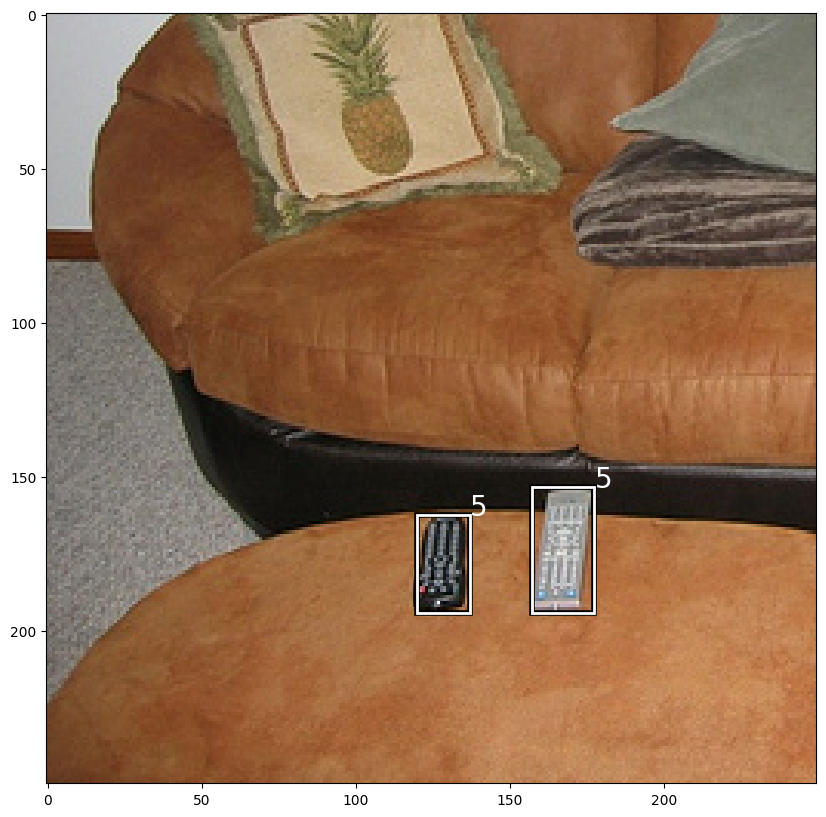

In [119]:
idx = 2

image, bboxes, class_labels, image_id = dataset[idx]
show_image(image, bboxes.tolist(), class_labels.tolist())

In [121]:
image, image.shape

(array([[[185, 185, 187],
         [186, 186, 188],
         [186, 187, 189],
         ...,
         [120, 122, 108],
         [112, 114, 101],
         [115, 117, 104]],
 
        [[186, 186, 188],
         [185, 185, 187],
         [184, 185, 187],
         ...,
         [116, 118, 104],
         [113, 115, 102],
         [117, 119, 106]],
 
        [[184, 184, 186],
         [182, 182, 184],
         [183, 184, 188],
         ...,
         [119, 121, 107],
         [120, 122, 109],
         [117, 119, 106]],
 
        ...,
 
        [[ 97,  57,  32],
         [103,  61,  37],
         [102,  60,  36],
         ...,
         [198, 131,  86],
         [187, 125,  78],
         [205, 143,  96]],
 
        [[ 94,  53,  31],
         [ 97,  57,  32],
         [ 99,  59,  34],
         ...,
         [198, 132,  84],
         [194, 130,  86],
         [195, 132,  88]],
 
        [[ 90,  52,  29],
         [ 91,  53,  30],
         [ 93,  56,  30],
         ...,
         [198, 132,  84],
  

In [122]:
bboxes.tolist()

[[119.92, 162.43, 137.17000000000002, 194.21000000000004],
 [157.35, 153.26999999999998, 177.51999999999998, 194.36]]

In [123]:
class_labels.tolist()

[5, 5]

We can verify this is correct by disabling the as_slice flag

In [124]:
ds_no_slice = ImageSliceDetectionDataset(ds, image_slices_df, as_slice=False)

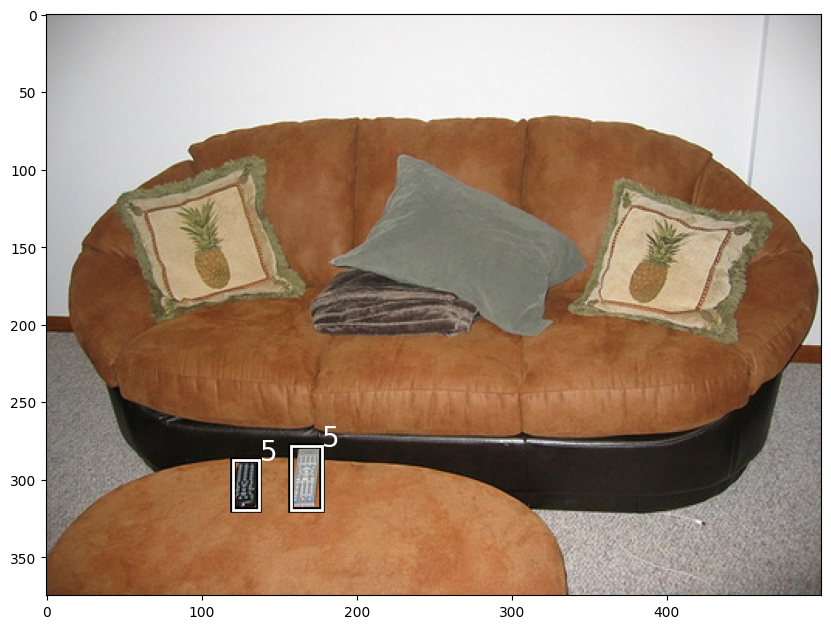

In [126]:
idx = 2

full_image, unscaled_bboxes, class_labels, image_id = ds_no_slice[idx]
show_image(full_image, unscaled_bboxes.tolist(), class_labels.tolist())

In [128]:
full_image, full_image.shape

(array([[[145, 146, 148],
         [145, 146, 148],
         [145, 146, 148],
         ...,
         [169, 168, 173],
         [168, 167, 172],
         [168, 167, 172]],
 
        [[146, 147, 149],
         [146, 147, 149],
         [146, 147, 149],
         ...,
         [171, 170, 175],
         [170, 169, 174],
         [170, 169, 174]],
 
        [[147, 148, 150],
         [148, 149, 151],
         [149, 149, 151],
         ...,
         [173, 173, 175],
         [172, 172, 174],
         [172, 172, 174]],
 
        ...,
 
        [[ 97,  57,  32],
         [103,  61,  37],
         [102,  60,  36],
         ...,
         [111, 103, 100],
         [ 98,  89,  84],
         [ 81,  72,  67]],
 
        [[ 94,  53,  31],
         [ 97,  57,  32],
         [ 99,  59,  34],
         ...,
         [112, 104, 101],
         [101,  92,  87],
         [ 88,  77,  71]],
 
        [[ 90,  52,  29],
         [ 91,  53,  30],
         [ 93,  56,  30],
         ...,
         [107,  99,  96],
  

In [129]:
unscaled_bboxes

array([[119.92, 287.43, 137.17, 319.21],
       [157.35, 278.27, 177.52, 319.36]])

In [130]:
class_labels

array([5, 5])

In [131]:
image_id

2

## Using a Random Crop Approach
Whilst deterministic slicing is required for inference, this may not be the best approach for training. The reason for this is that, if the images in the dataset are fairly uniform, the model will only ever see the same set of image crops; which may affect its generalisation. An alternative approach would be to randomly crop the image at runtime during training, to add some variation in the images that the model sees - hopefully making the model more robust!

Let's explore how we can modify our ImageSliceDataset to incorporate this.

In [133]:
import albumentations as A
import numpy as np


class ImageSliceDetectionDataset:
    def __init__(
        self,
        ds_adaptor,
        slices_df,
        as_slice=True,
        slice_height=250,
        slice_width=250,
        deterministic_crop=True,
        transforms=None,
        bbox_min_area=0.1,
        bbox_min_visibility=0.1,
    ):
        self.ds = ds_adaptor
        self.slices_df = slices_df
        self.as_slice = as_slice
        self.slice_height = slice_height
        self.slice_width = slice_width
        self.deterministic_crop = deterministic_crop
        self.transforms = transforms
        self.bbox_min_area = bbox_min_area
        self.bbox_min_visibility = bbox_min_visibility

    def __len__(self) -> int:
        return len(self.slices_df)

    def _apply_transforms(self, transform_list, image, boxes, classes):
        transforms = A.Compose(
            transform_list,
            bbox_params=A.BboxParams(
                format="pascal_voc",
                min_visibility=self.bbox_min_visibility,
                min_area=self.bbox_min_area,
                label_fields=["labels"],
            ),
        )

        transformed = transforms(image=image, bboxes=boxes, labels=classes)

        image = transformed["image"]
        boxes = np.array(transformed["bboxes"])
        classes = np.array(transformed["labels"])

        return image, boxes, classes

    def create_deterministic_crop_transforms(self, slice_corners):
        return [
            A.Crop(*slice_corners),
            A.PadIfNeeded(self.slice_height, self.slice_width, border_mode=0),
        ]

    def create_random_crop_transforms(self):
        return [
            A.RandomResizedCrop(self.slice_height, self.slice_width, scale=(0.08, 0.4))
        ]

    def __getitem__(self, index):
        row = self.slices_df.iloc[index]

        file_name = row.file_name
        adaptor_idx = self.ds.file_name_to_idx[file_name]

        image, bboxes, class_labels, image_id = self.ds[adaptor_idx]

        transforms = []

        if self.as_slice:
            if self.deterministic_crop:
                slice_bbox = row[["xmin", "ymin", "xmax", "ymax"]].values
                transforms.extend(self.create_deterministic_crop_transforms(slice_bbox))

            else:
                transforms.extend(self.create_random_crop_transforms())

        if self.transforms:
            transforms.extend(self.transforms)

        image, bboxes, class_labels = self._apply_transforms(
            transforms, image, bboxes, class_labels
        )

        return image, bboxes, class_labels, index

Here, we have added a resized random crop transform which will be applied if the deterministic_crop flag is not enabled. This way, we can easily switch between the two behaviours.

In [134]:
dataset = ImageSliceDetectionDataset(ds, image_slices_df, deterministic_crop=False)

Loading the same image several times, we can see that different crops are taken.

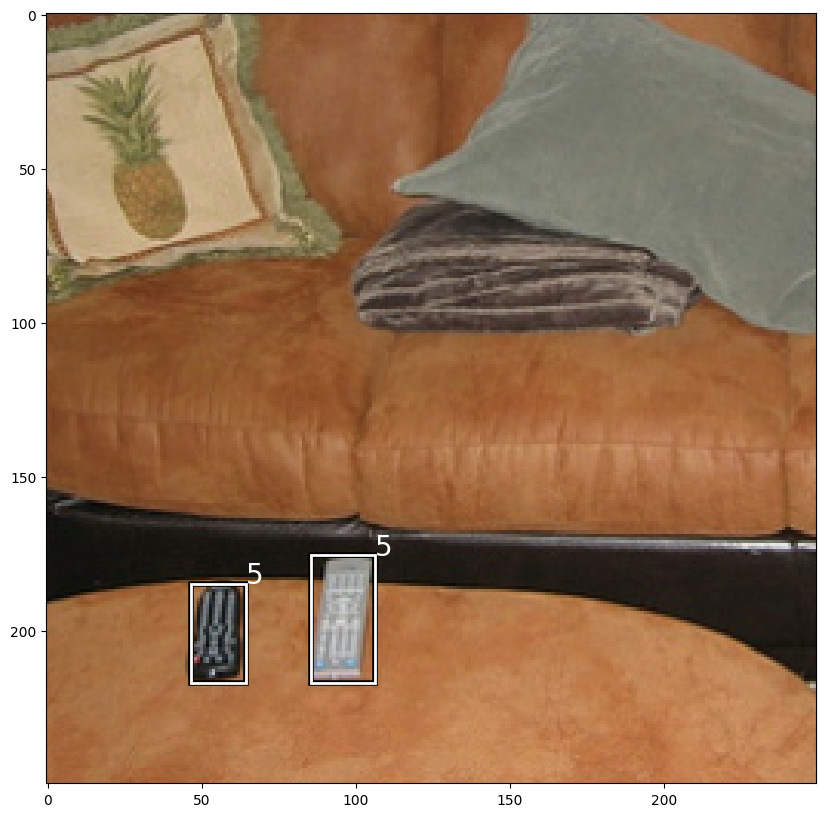

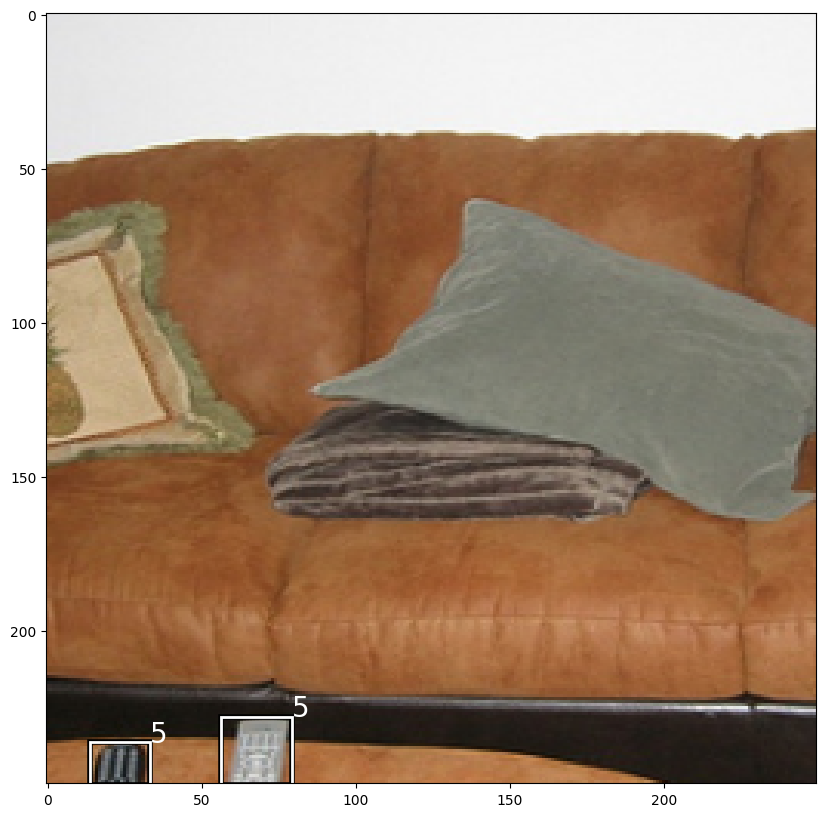

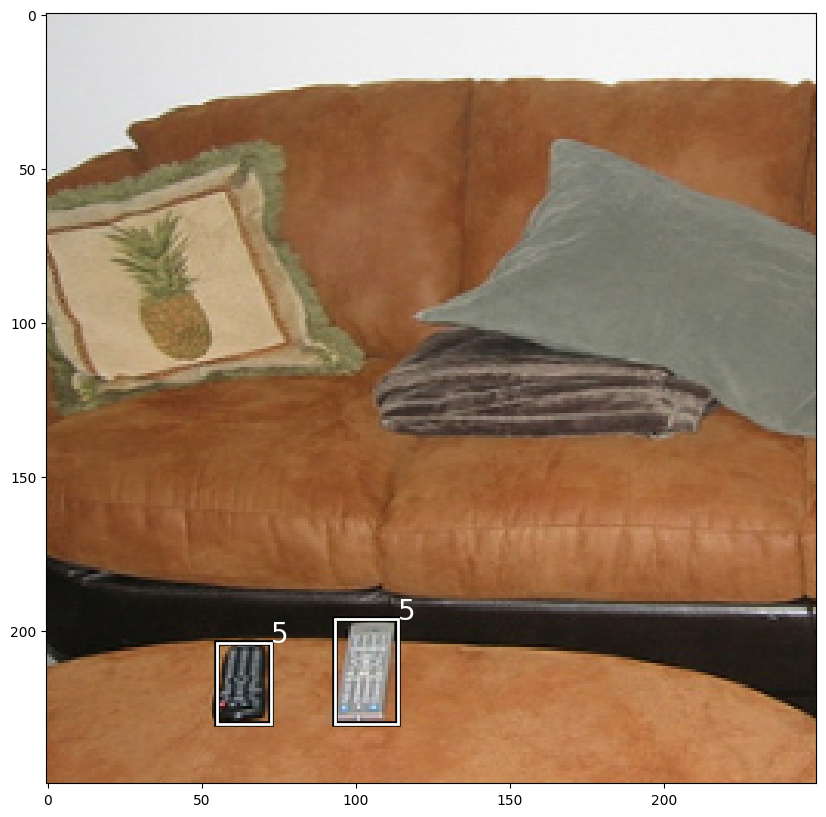

In [138]:
idx = 2
for i in range(3):
    image, bboxes, class_labels, image_id = dataset[idx]
    show_image(image, bboxes.tolist(), class_labels.tolist())

## Incorporating additional transforms
For even more variation, we can use additional albumentations transforms, as demonstrated below:

In [139]:
dataset = ImageSliceDetectionDataset(ds, image_slices_df, deterministic_crop=False, transforms=[A.HorizontalFlip()])

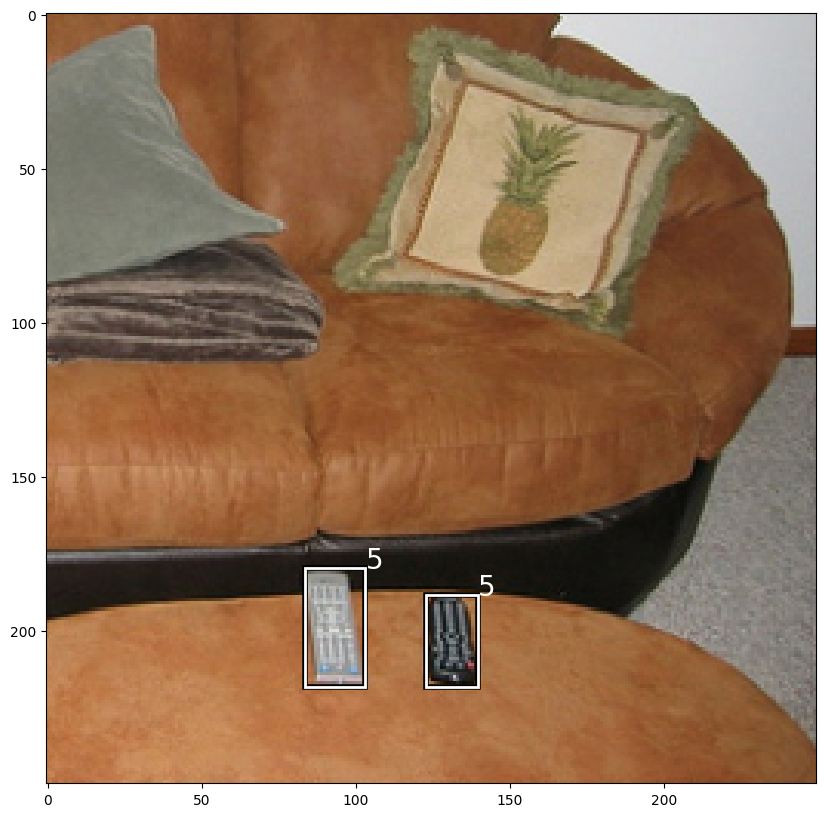

In [143]:
idx = 2
image, bboxes, class_labels, image_id = dataset[idx]
show_image(image, bboxes.tolist(), class_labels.tolist())

## Inverse transforming our labels
After using slices of our image for inference, we may wish to convert our predicted bounding boxes so that they are relative to the whole image, let's explore how we can do this.

First, let's retrieve our image slice, and relative bounding boxes:

In [144]:
dataset = ImageSliceDetectionDataset(ds, image_slices_df, deterministic_crop=True, as_slice=True)

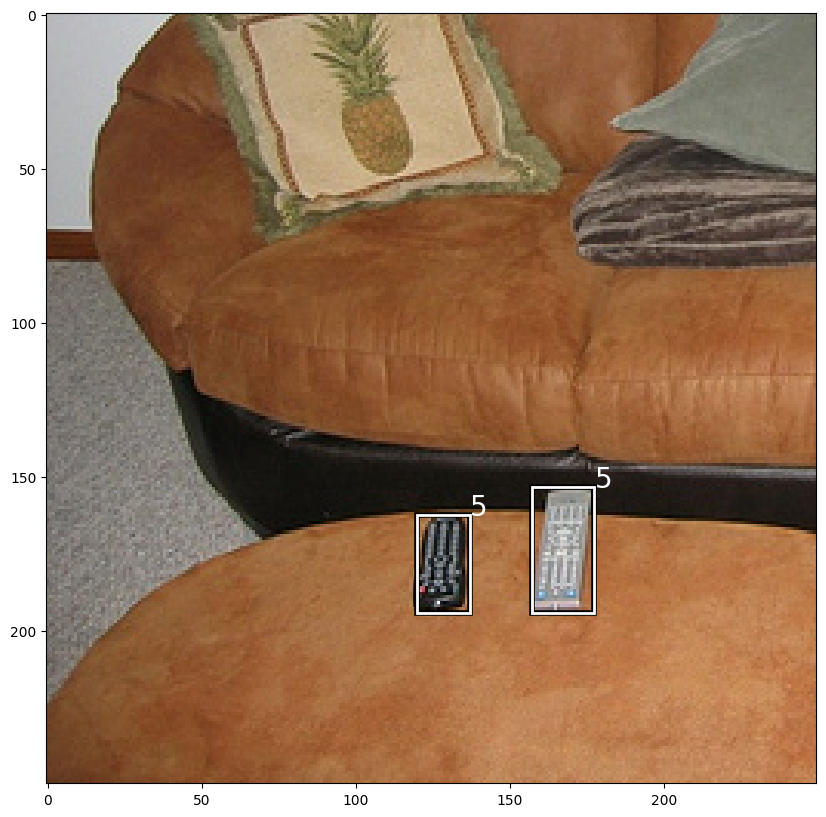

In [146]:
idx = 2

image, bboxes, class_labels, slice_id = dataset[idx]
show_image(image, bboxes.tolist(), class_labels.tolist())

To convert our boxes, we will also need the coordinates of our image slice. These are not returned from our dataset, but we can retrieve this easily from our slices DataFrame using the returned slice id of our image slice.

In [152]:
bboxes

array([[119.92, 162.43, 137.17, 194.21],
       [157.35, 153.27, 177.52, 194.36]])

In [148]:
slice_id

2

In [149]:
slice_bbox = dataset.slices_df.query('slice_id == @slice_id')[['xmin', 'ymin', 'xmax', 'ymax']].values.tolist()[0]; slice_bbox

[0, 125, 250, 375]

As our slices and bounding boxes are both expressed in xyxy format, we can convert our boxes so that they are relative to the whole image simply by adding the starting x and y coordinate values to our bounding box, as demonstrated below:

In [150]:
s_xmin, s_ymin, s_xmax, s_ymax = slice_bbox
rescaled_bboxes = bboxes + np.array([s_xmin, s_ymin, s_xmin, s_ymin])

In [151]:
rescaled_bboxes

array([[119.92, 287.43, 137.17, 319.21],
       [157.35, 278.27, 177.52, 319.36]])

To verify that this has worked correctly, let's load the whole image and our ground truth boxes.

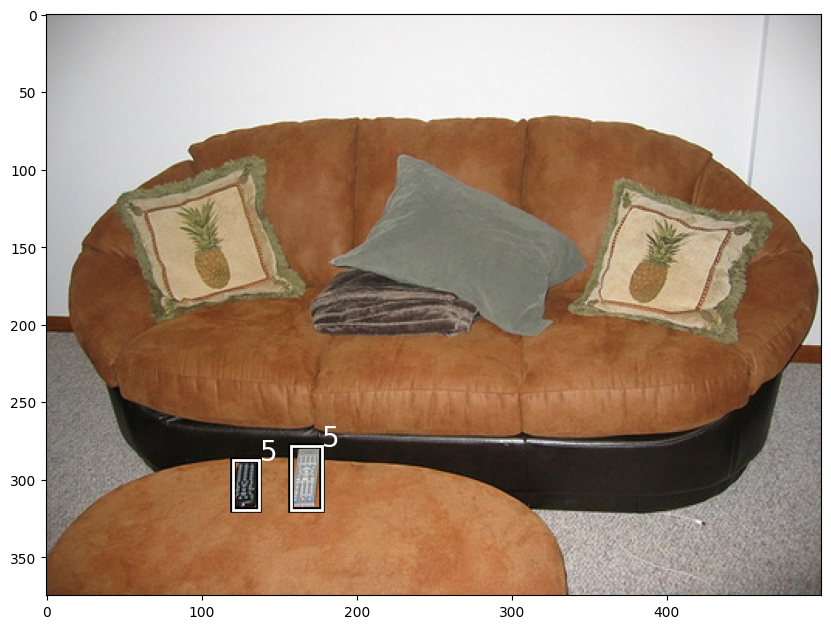

In [153]:
dataset.as_slice = False
full_image, unscaled_bboxes, class_labels, slice_id = dataset[idx]
show_image(full_image, unscaled_bboxes.tolist(), class_labels.tolist())

Plotting our re-scaled boxes, we can verify that the output is the same.

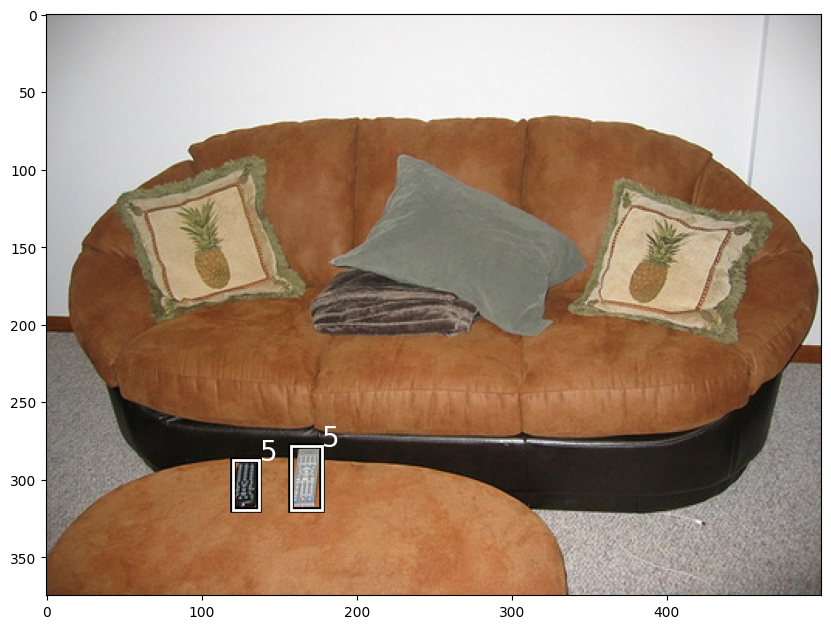

In [154]:
show_image(full_image, rescaled_bboxes.tolist(), class_labels.tolist())

The only gotcha to watch out for here are the edge cases where a bounding box is split across multiple slices; as any part of a box that falls outside of the slice dimensions will be discarded during the initial scaling, it will not be possible to reconstruct this completely. During inference, these cases will result in a box only being drawn around the part of the object that was present in the slice used, when the box is visualised on the whole image, which is what we would expect.

In general, the only way that we can avoid this happening is to try and ensure that the entire object that we are interested in detecting is contained in an image slice; we can do this by increasing the amount of overlap between slices.

## Conclusion
Whilst it is likely that the exact implementation may have to be adapted depending on your specific use case, hopefully this has provided a clear starting point, and demonstrated the ideas behind an approach which has worked successfully for me!

In [155]:
"""20230628 WE START THE IMPLEMENTATIN ON PYCHARM AND ON MONDAY 3 JULY ON VSC WITH TK --> TO BE DELIVERED ON THRUSDAY 6 JULY"""

'20230628 WE START THE IMPLEMENTATIN ON PYCHARM AND ON MONDAY 3 JULY ON VSC WITH TK --> TO BE DELIVERED ON THRUSDAY 6 JULY'